In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_i.shape

(60, 1)

In [5]:
sales_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_i['Sales'].sum()

5783407

Text(0.5, 1.0, 'Product I')

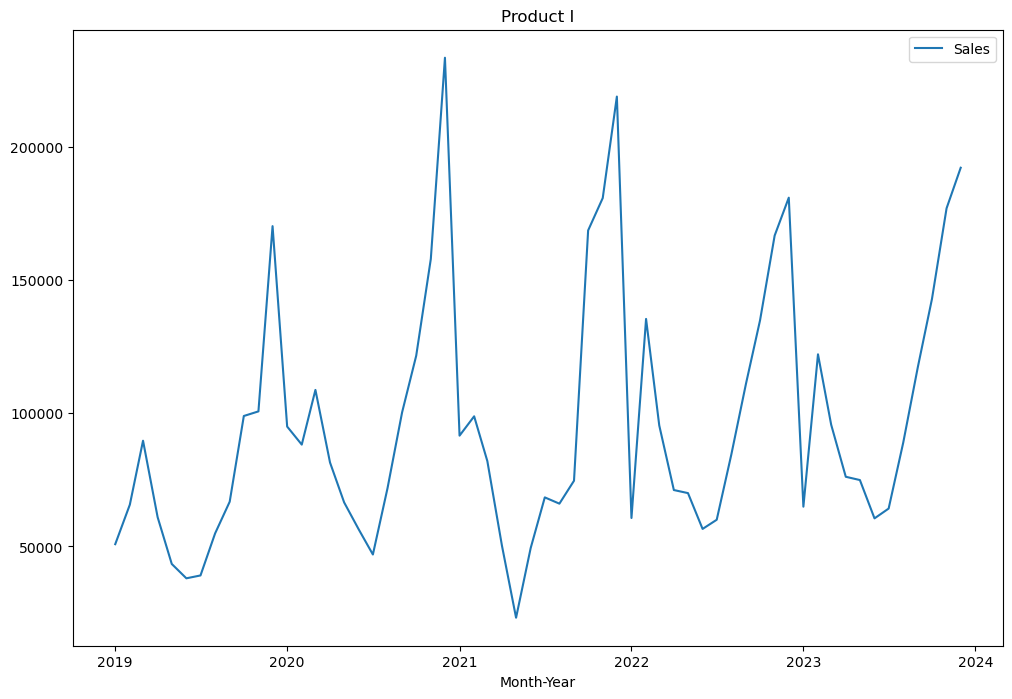

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i)
plt.title('Product I')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_i)

ADF Statistics: -2.5790376657087335
p- value: 0.09740761251652458
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_i_diff= sales_i.diff().dropna()

Text(0.5, 1.0, 'Product I- First Difference')

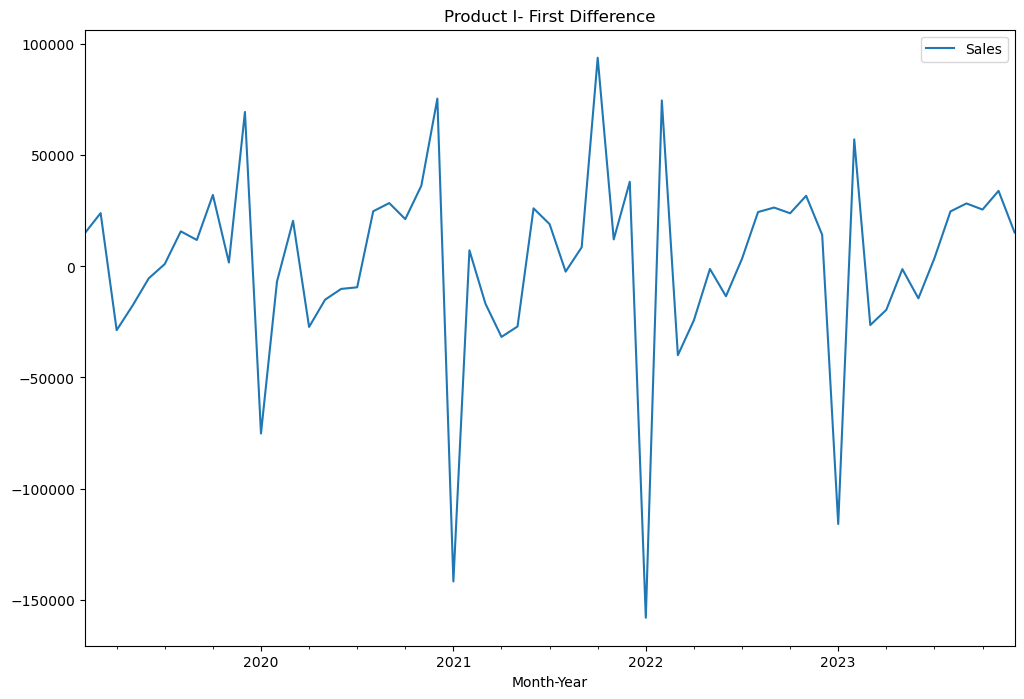

In [11]:
sales_i_diff.plot(figsize=(12,8))
plt.title('Product I- First Difference')

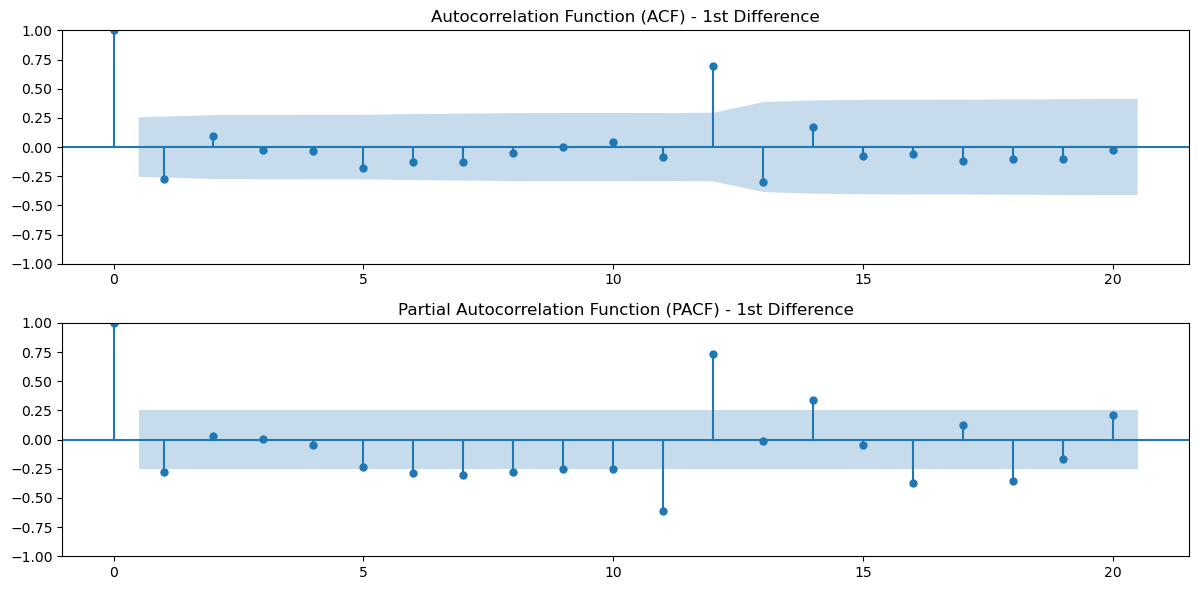

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_i_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_i_diff)

ADF Statistics: -3.6173278718862623
p- value: 0.005438267272077221
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_i[:57]
test=sales_i[57:]

In [15]:
len(train)

57

In [16]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_i, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_i)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1350.649400  1364.826862  48746.309828  2.687603e+09  51842.096656
17  5  2  1351.923144  1368.125958  45781.416550  2.373659e+09  48720.214775
16  5  1  1355.754605  1369.932067  49206.682932  2.768756e+09  52618.966085
10  3  1  1356.918473  1367.045231  62501.126198  4.507169e+09  67135.451308
13  4  1  1357.145727  1369.297837  54289.931327  3.443249e+09  58679.205835
5   1  2  1357.575849  1365.677256  68193.927706  5.202710e+09  72129.811583
8   2  2  1357.751804  1367.878563  64479.736262  4.811383e+09  69364.135097
3   1  0  1358.365311  1362.416014  60030.886816  3.995808e+09  63212.402081
1   0  1  1358.699510  1362.750214  63104.589347  4.405910e+09  66377.031315
11  3  2  1358.966518  1371.118629  64869.215824  4.860801e+09  69719.443593
6   2  0  1360.369778  1366.445833  59676.386629  3.952256e+09  62866.970381
4   1  1  1360.418011  1366.494066  59615.135144  3.945005e+09  62809.276791

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -668.325
Date:                Thu, 09 May 2024   AIC                           1350.649
Time:                        18:39:24   BIC                           1364.827
Sample:                    01-01-2019   HQIC                          1356.146
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0992      0.308      3.564      0.000       0.495       1.704
ar.L2         -0.1632      0.393     -0.415      0.678      -0.934       0.607
ar.L3         -0.1921      0.426     -0.451      0.6

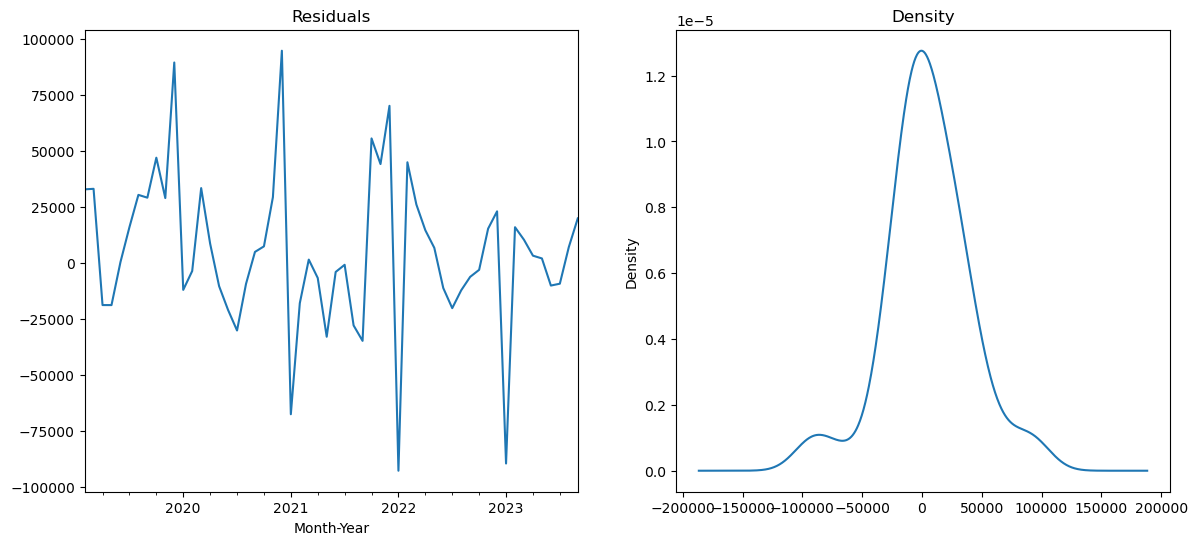

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

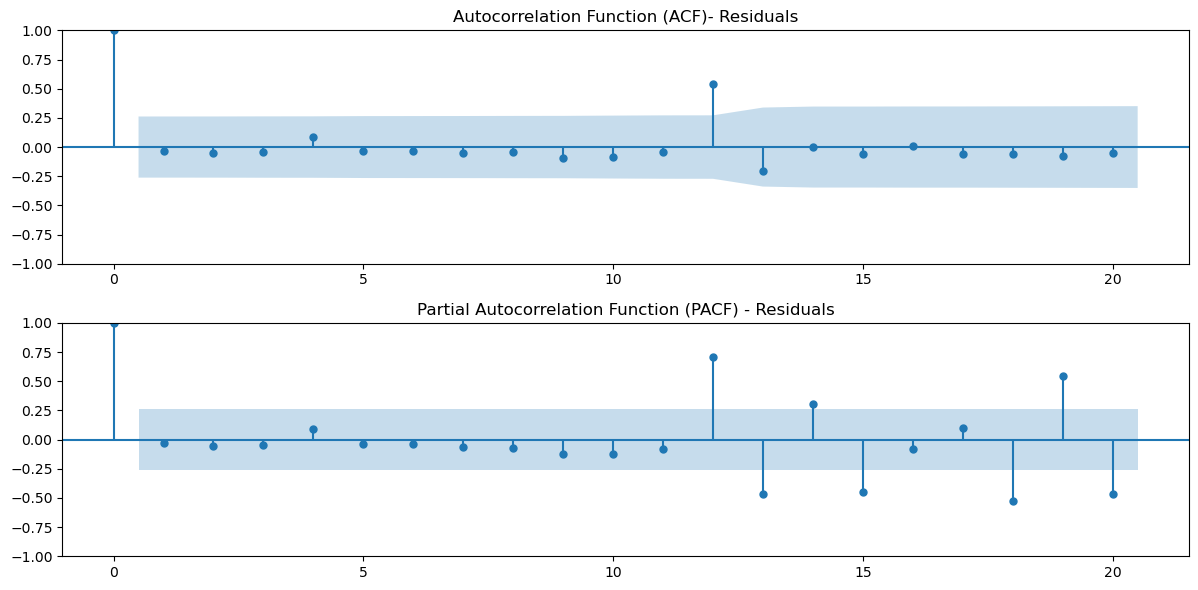

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

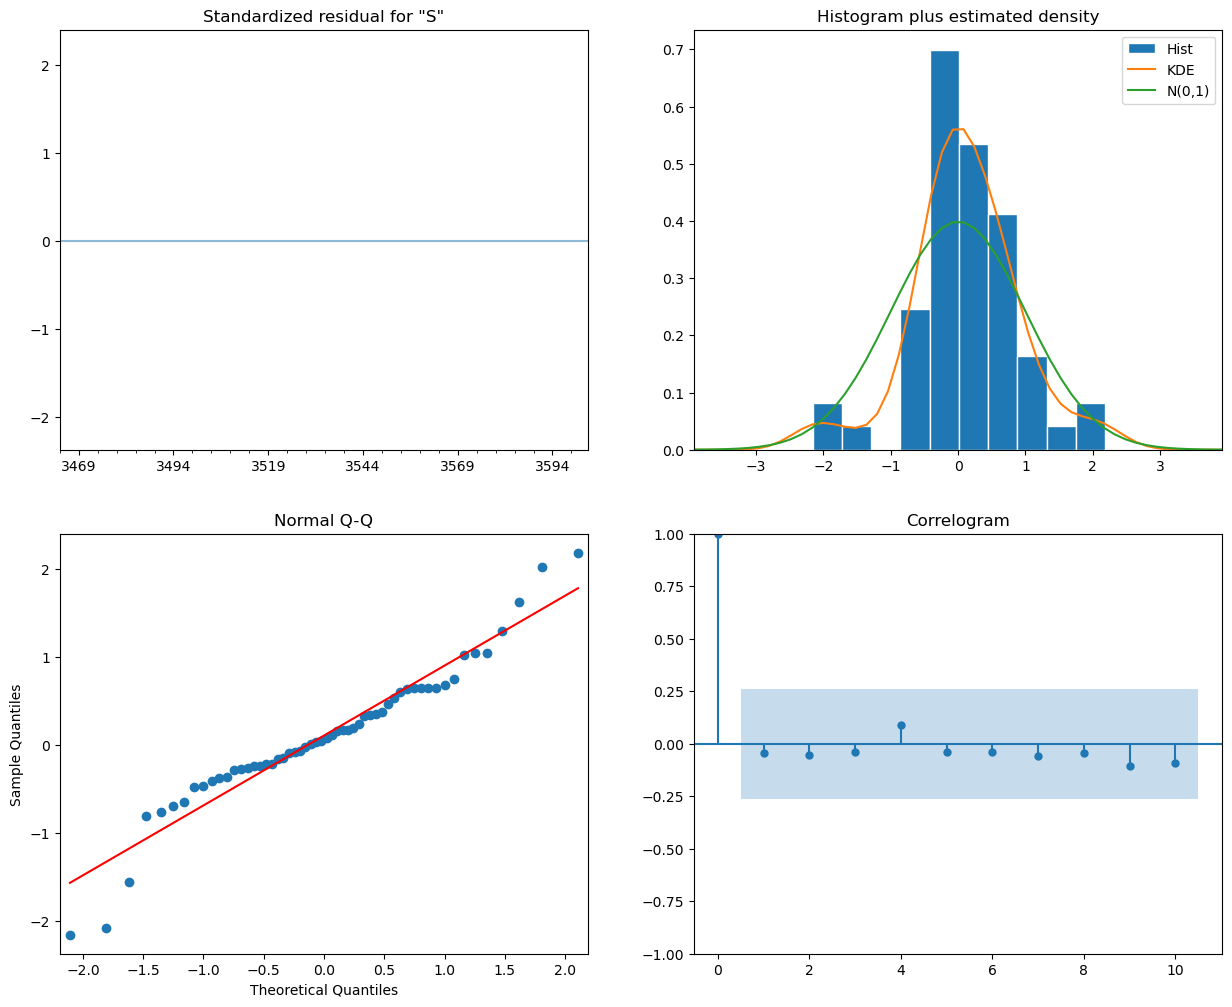

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_i['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_i.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_i)-1), dynamic = True)
sales_i['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product I')

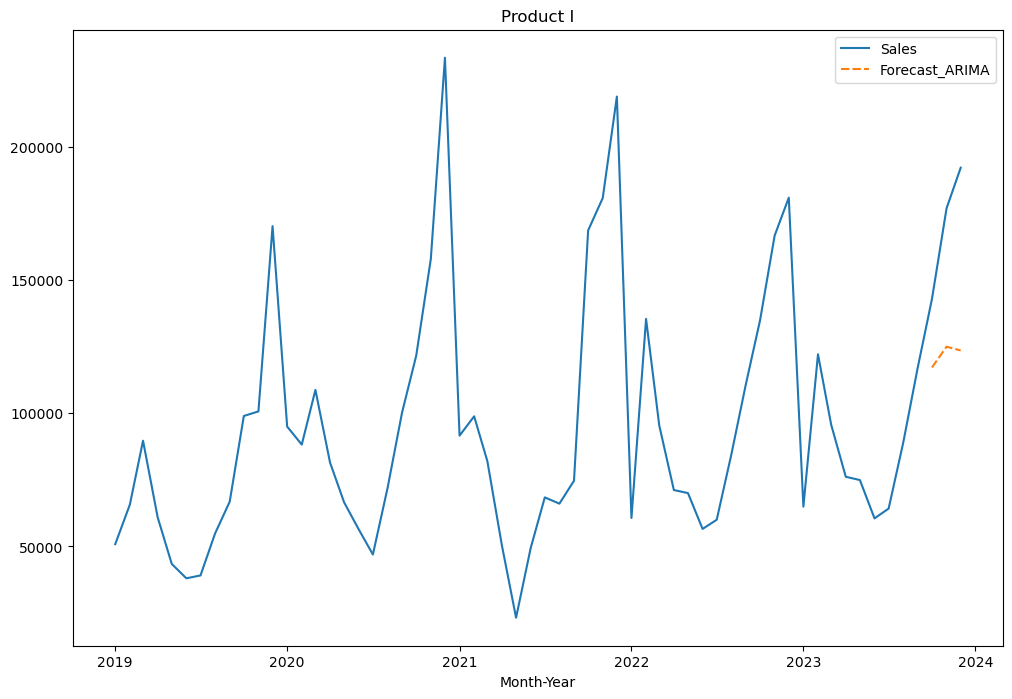

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i)
plt.title('Product I')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 48746.30982792494
MAPE - ARIMA: 0.27685716392585075
MSE - ARIMA: 2687602985.7208495
RMSE - ARIMA: 51842.096656297086


# SARIMA

In [28]:
import statsmodels.api as sm

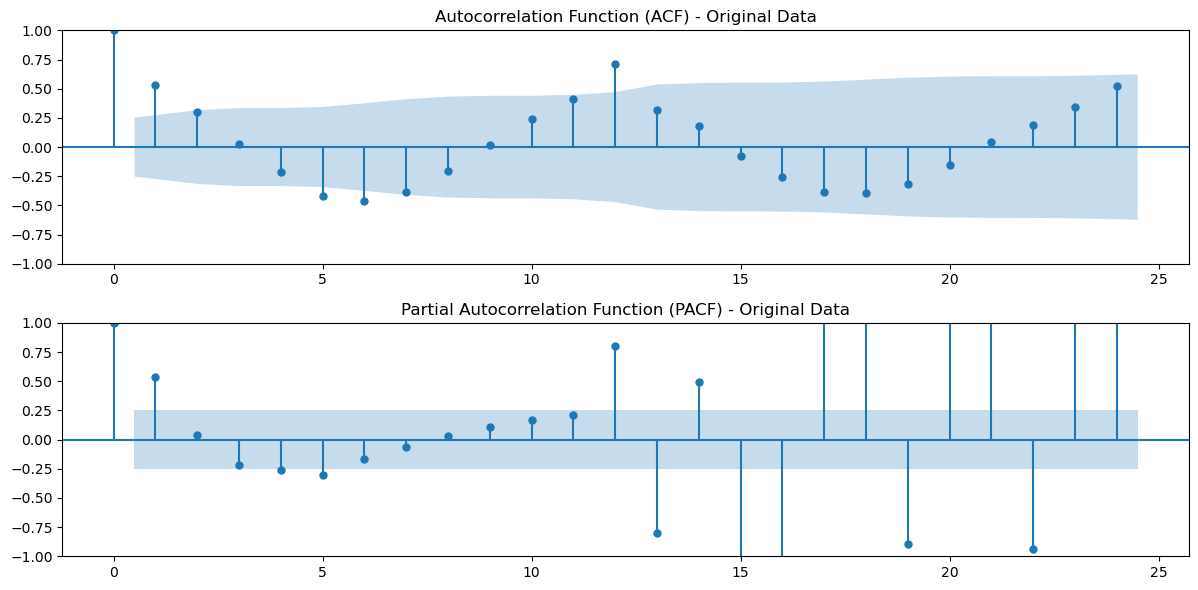

In [29]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_i['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

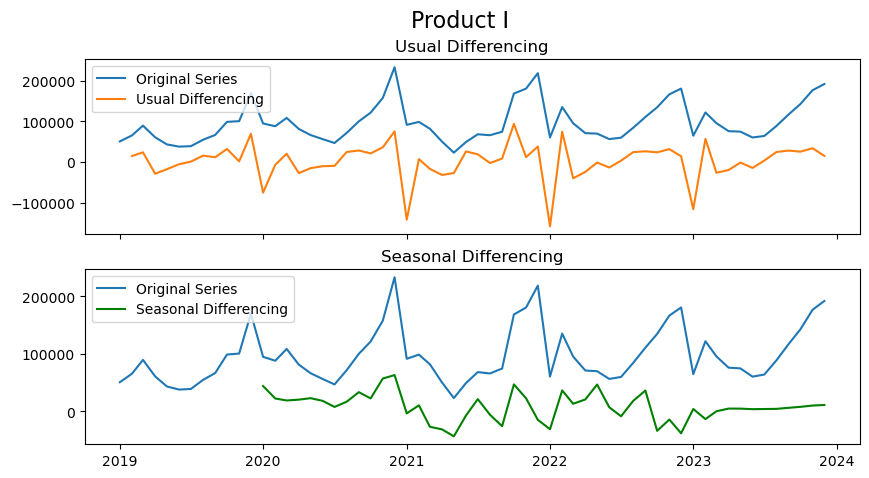

In [30]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_i['Sales'], label='Original Series')
axes[0].plot(sales_i['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_i['Sales'], label='Original Series')
axes[1].plot(sales_i['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product I', fontsize=16)
plt.show()

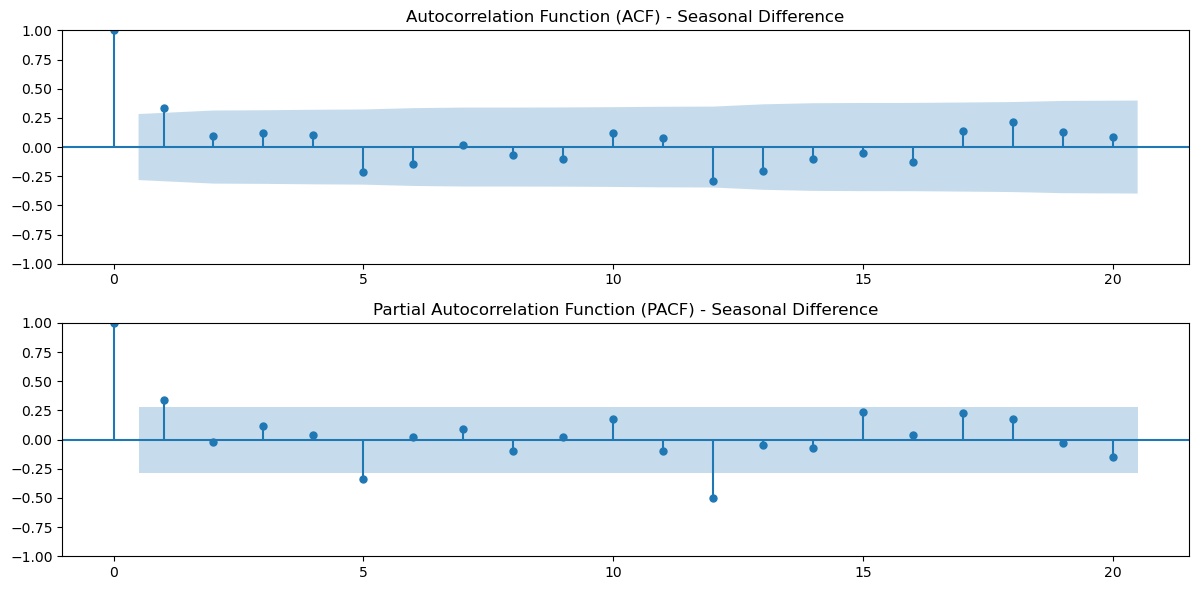

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_i['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_i['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

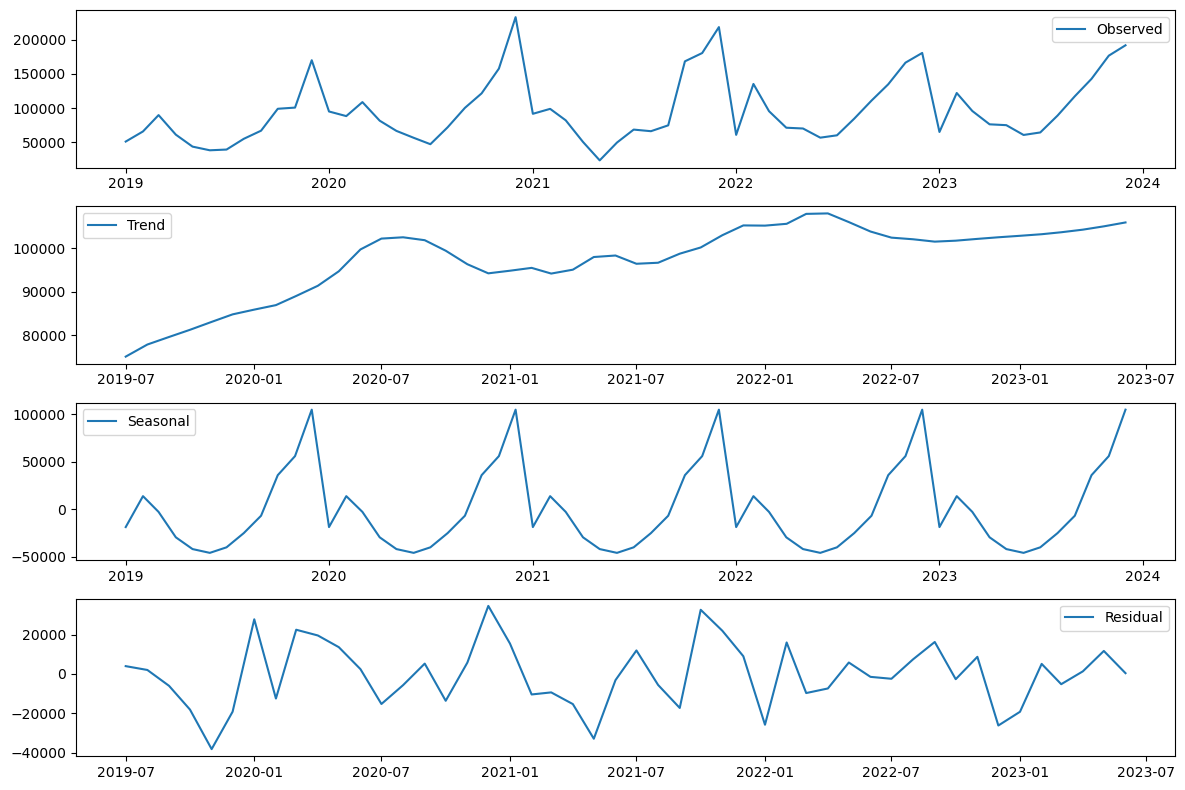

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_i['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
order_SARIMAX=[]
# Loop over P order
for P in range(4):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [34]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

   P  Q          aic          bic           mae           mse
0  0  0  1032.779834  1045.269161   4603.130109  2.305976e+07
6  3  0  1033.460876  1051.302772  12045.197759  1.623336e+08
1  0  1  1034.669687  1048.943205   6650.203742  4.582175e+07
2  1  0  1034.697374  1048.970891   6126.314390  3.926707e+07
5  2  1  1034.861762  1052.703658  20598.700977  4.243814e+08
7  3  1  1035.123897  1054.749983  20543.395141  4.639291e+08
4  2  0  1035.509073  1051.566780   9638.228860  1.002581e+08
3  1  1  1036.584185  1052.641891   7266.719629  5.367578e+07


In [35]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(0,1,0,12))
sarima_model=sarima.fit()

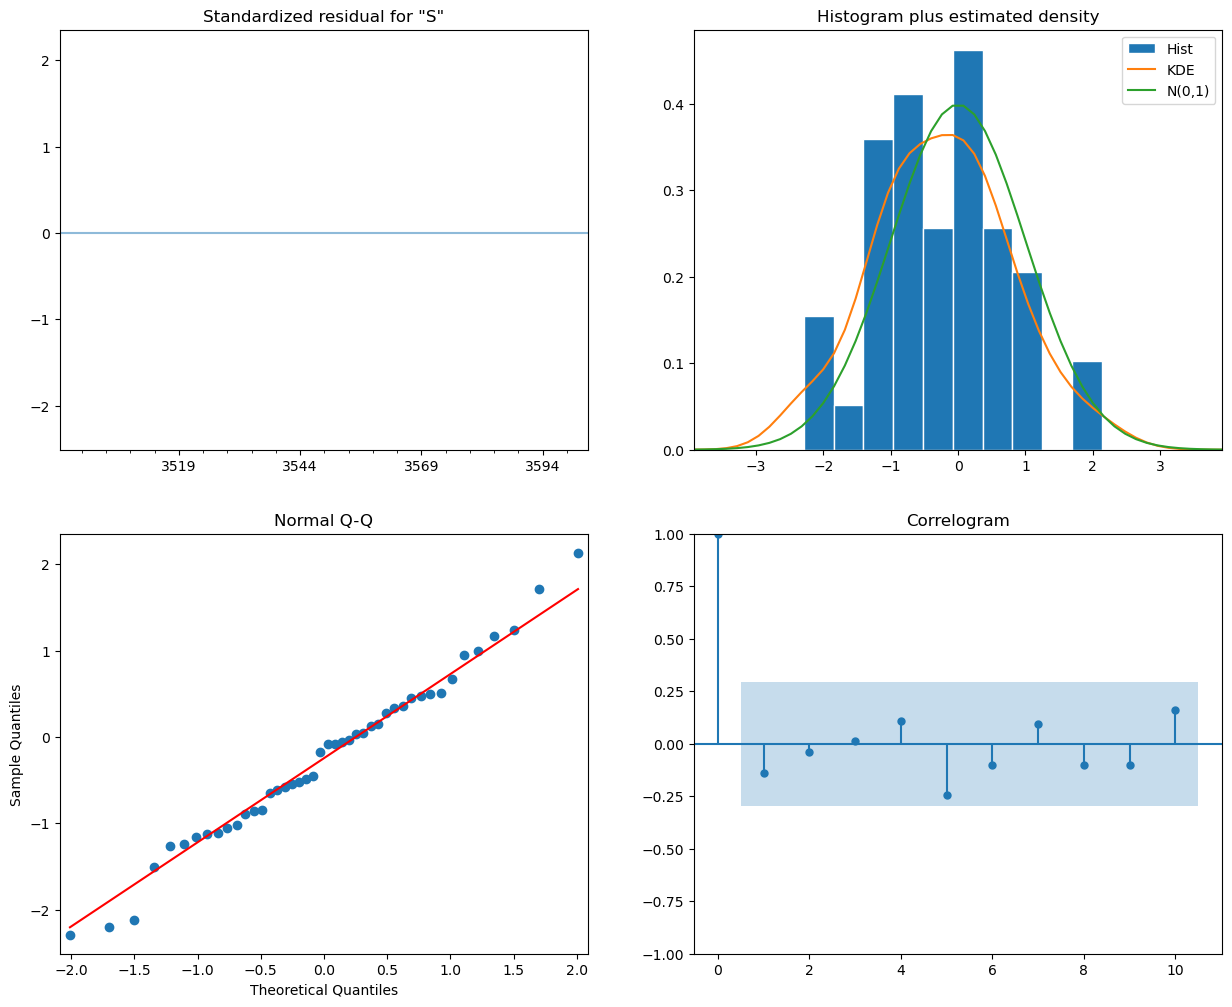

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [38]:
sales_i['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product I')

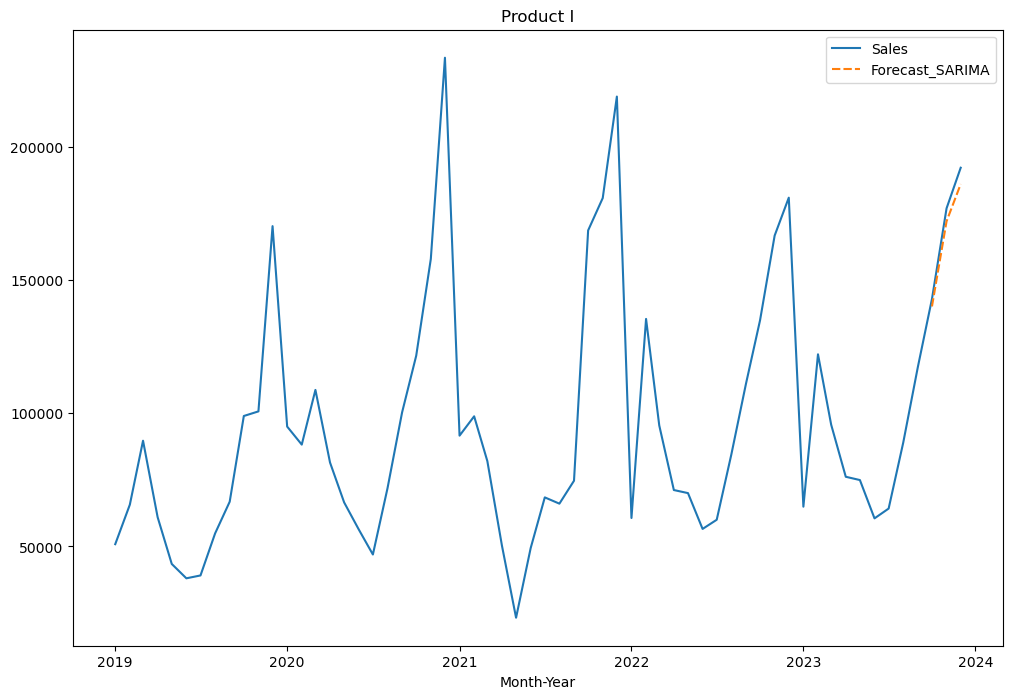

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_SARIMA']])
plt.title('Product I')

In [40]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 4603.13
MAPE - SARIMA: 0.026
MSE - SARIMA: 23059756.369
RMSE - SARIMA: 4802.058


# AUTO-ARIMA

In [42]:
import pmdarima as pm

In [43]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=4 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.635, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1031.916, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1032.693, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1031.954, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1034.979, Time=0.26 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1033.223, Time=0.98 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1030.337, Time=8.44 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=9.60 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=1034.519, Time=4.51 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=1032.880, Time=2.49 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=1034.668, Time=4.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1028.951, Time=0.07 sec
 ARIMA(0,1,1)(0

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [44]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -509.945
Date:                             Thu, 09 May 2024   AIC                           1025.890
Time:                                     18:44:15   BIC                           1031.242
Sample:                                 01-01-2019   HQIC                          1027.875
                                      - 09-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5196      0.193      2.693      0.007       0.141       0.898
ma.L1         -0.8926      0.094     -9.532      0.000      -1.076      -0.709
sigma2      6.955e+08   7.97e-11   8.73e+18      0.000    6.96e+08    6.96e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.34   Prob(JB):                         0.77
Heteroskedasticity (H):               0.68   Skew:                             0.25
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.85e+34. Standard errors may be unstable.
"""

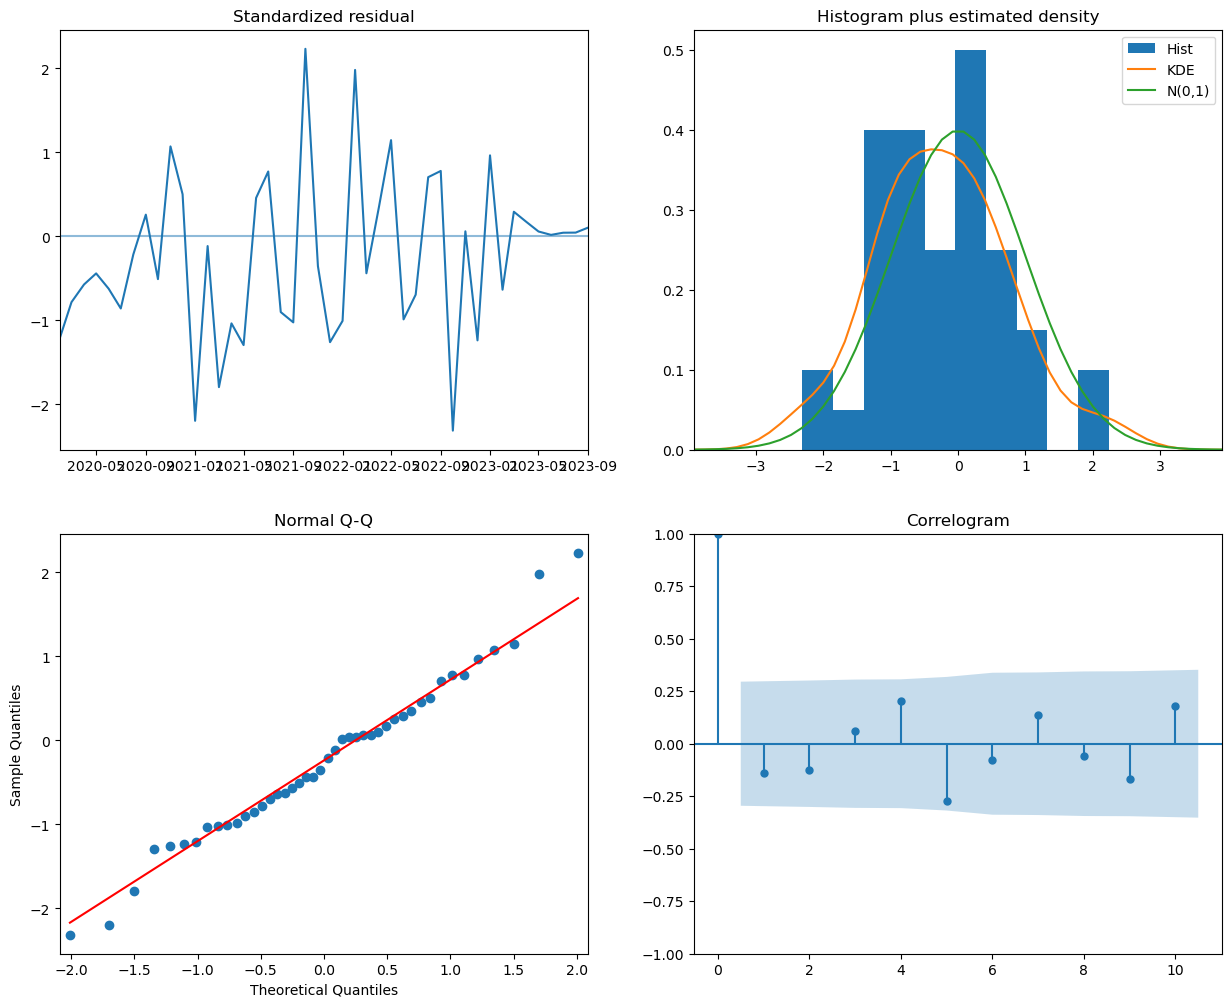

In [45]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [46]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_i['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_i.plot()

Text(0.5, 1.0, 'Product I')

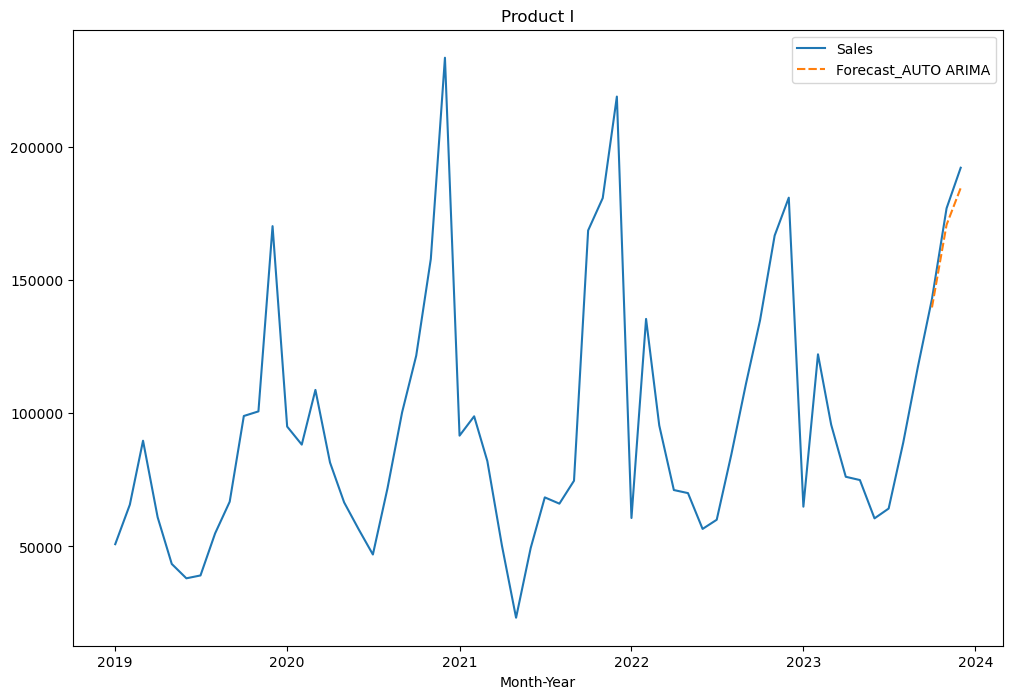

In [47]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product I')

In [48]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 5660.954304008454
MAPE - AUTO ARIMA: 0.03229542751150605
MSE - AUTO ARIMA: 35438850.84683783
RMSE - AUTO ARIMA: 5953.053909283691


In [49]:
sales_i.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,64906,NaN,NaN,NaN
2023-02-01,122096,NaN,NaN,NaN
2023-03-01,95682,NaN,NaN,NaN
2023-04-01,76134,NaN,NaN,NaN
2023-05-01,74900,NaN,NaN,NaN
2023-06-01,60518,NaN,NaN,NaN
2023-07-01,64200,NaN,NaN,NaN
2023-08-01,88953,NaN,NaN,NaN
2023-09-01,117297,NaN,NaN,NaN


In [50]:
sales_i.mean()

Sales                   96390.116667
Forecast_ARIMA         121887.356839
Forecast_SARIMA        166030.536558
Forecast_AUTO ARIMA    164972.712363
dtype: float64

In [51]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,48746.309828,0.276857,2.687603e+09,51842.096656
AUTO ARIMA,5660.954304,0.032295,3.543885e+07,5953.053909
SEASONAL ARIMA,4603.130109,0.026367,2.305976e+07,4802.057514


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1043.169, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1041.222, Time=0.10 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1042.017, Time=0.27 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1042.589, Time=0.08 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1042.261, Time=0.18 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=1042.731, Time=0.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1041.275, Time=0.28 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1041.101, Time=0.65 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=1041.952, Time=0.88 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1038.349, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1038.205, Time=0.19 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1039.774, Time=0.29 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1038.621, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1040.013, Time=0.60 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1039.679, Time=0.76

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -515.826
Date:                            Wed, 08 May 2024   AIC                           1037.651
Time:                                    20:04:57   BIC                           1043.071
Sample:                                01-01-2019   HQIC                          1039.672
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4601.1616   3574.446      1.287      0.198   -2404.624    1.16e+04
ar.L1          0.2861      0.114      2.512      0.012       0.063       0.509
sigma2       5.38e+08      0.008   6.43e+10      0.000    5.38e+08    5.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.73   Prob(JB):                         0.90
Heteroskedasticity (H):               0.79   Skew:                             0.09
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+27. Standard errors may be unstable.
"""

In [20]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_i['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product I')

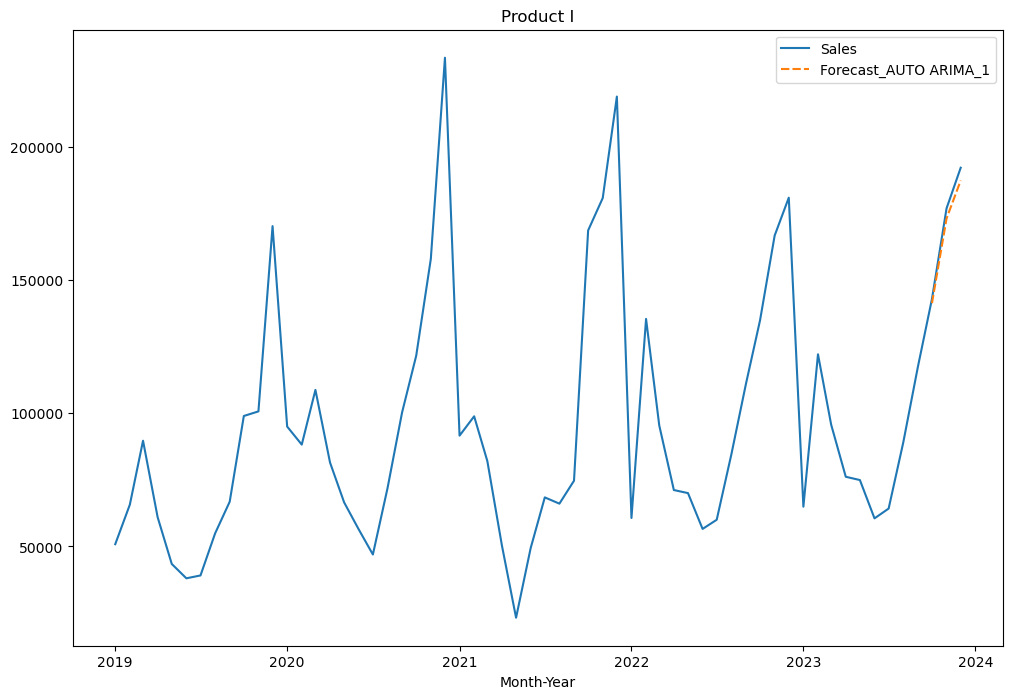

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_i[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product I')

In [22]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 3397.9598212548103
MAPE - AUTO ARIMA: 0.019210247221910056
MSE - AUTO ARIMA: 13327941.84370702
RMSE - AUTO ARIMA: 3650.7453819332595
